In [35]:
import sys
import os


if '/Users/zhang/PycharmProjects/strategy_engine_v2' not in sys.path:
    sys.path.append("/Users/zhang/PycharmProjects/strategy_engine_v2")
os.environ['config.dir'] = "/Users/zhang/PycharmProjects/strategy_engine_v2/interface"
os.environ['config.log'] = "/Users/zhang/PycharmProjects/strategy_engine_v2/interface/log_jupyter.yaml"
# 如果没有日志目录的话，则创建
if not os.path.exists("log"):
    os.makedirs("log")


In [47]:
# 计算日内回报、日间回报、以及总回报序列
from se.domain2.time_series.time_series import HistoryDataQueryCommand, TimeSeriesRepo, TimeSeries
from trading_calendars import get_calendar
import pandas as pd
import numpy as np
from se import *
start = pd.Timestamp("2019-07-09", tz='Asia/Shanghai')
end = pd.Timestamp("2021-02-05", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['SPCE_STK_USD_SMART'])
command.with_calendar(get_calendar("NYSE"))
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)
ts: TimeSeries = ts_repo.find_one("ibAdjustedDailyBar")

df = ts.history_data(command)
df = df.droplevel(level=1)
# 注意origin的tz必须跟原始的DataFrame的DatetimeIndex的timezone相同
pre_open_to_close_rets = (df['close'] / df['open']).apply(np.log)
pre_close_to_close_rets = (df['close'] / df['close'].shift(1)).apply(np.log)
next_close_to_open_rets = (df['open'].shift(-1) / df['close']).apply(np.log)
next_close_to_close_rets = (df['close'].shift(-1) / df['close']).apply(np.log)
rets_on_close = pd.DataFrame({"pre_oc": pre_open_to_close_rets, "pre_cc": pre_close_to_close_rets,
                     "next_co": next_close_to_open_rets, 'next_cc': next_close_to_close_rets})

next_open_to_close_rets = (df['close'] / df['open']).apply(np.log)
next_open_to_open_rets = (df['open'].shift(-1) / df['open']).apply(np.log)
pre_close_to_open_rets = (df['open'] / df['close'].shift(1)).apply(np.log)
pre_open_to_open_rets = (df['open'] / df['open'].shift(1)).apply(np.log)

rets_on_open = pd.DataFrame({
    'pre_co': pre_close_to_open_rets,
    "pre_oo": pre_open_to_open_rets,
    "next_oc": next_open_to_close_rets,
    "next_oo": next_open_to_open_rets,
})
rets_on_open.index = rets_on_open.index - pd.Timedelta(hours=6, minutes=30)
rets_on_close = rets_on_close.dropna()
rets_on_open = rets_on_open.dropna()

In [49]:
rets_on_open.head()

,pre_co,pre_oo,next_oc,next_oo
visible_time,,,,
2019-07-09 21:30:00+08:00,0.046825,0.045867,-0.022203,-0.011965
2019-07-10 21:30:00+08:00,0.010237,-0.011965,-0.001854,-0.004640
2019-07-11 21:30:00+08:00,-0.002787,-0.004640,-0.014996,-0.009346
2019-07-12 21:30:00+08:00,0.005650,-0.009346,-0.001880,0.002813
2019-07-15 21:30:00+08:00,0.004693,0.002813,-0.009407,-0.007519


In [54]:
# 考察相关性
# 一阶自相关
rets_on_close.corr(method='spearman')


,pre_oc,pre_cc,next_co,next_cc
pre_oc,1.000000,0.772109,0.171441,0.052491
pre_cc,0.772109,1.000000,0.182268,0.051673
next_co,0.171441,0.182268,1.000000,0.471166
next_cc,0.052491,0.051673,0.471166,1.000000


In [65]:
rets_on_open.corr(method="spearman")

,pre_co,pre_oo,next_oc,next_oo
pre_co,1.000000,0.587130,-0.043969,0.017056
pre_oo,0.587130,1.000000,-0.015352,0.048665
next_oc,-0.043969,-0.015352,1.000000,0.834326
next_oo,0.017056,0.048665,0.834326,1.000000


In [102]:
rets_on_close.iloc[0:2]

,pre_oc,pre_cc,next_co,next_cc
visible_time,,,,
2019-07-10 04:00:00+08:00,-0.022203,0.024622,0.010237,0.008384
2019-07-11 04:00:00+08:00,-0.001854,0.008384,-0.002787,-0.017782


In [100]:
# 上面的相关系数表明在过去的一年半的时间内， pre_cc与next_co之间存在比较强的正相关， 但是我们也不应该
# 期待这种正相关性会一直持续下去，如果我们将过去的一年半的时间，按照某个周期进行滑动，然后计算每个滑动窗口的相关性，
# 根据这个结果数据，我们可以得出相关系数显著的时间比例
corrs = rets_on_close['pre_cc'].rolling(window=30).corr(rets_on_close['next_co'])
corrs.dropna()

visible_time
2019-08-20 04:00:00+08:00    0.261656
2019-08-21 04:00:00+08:00   -0.529312
2019-08-22 04:00:00+08:00   -0.447054
2019-08-23 04:00:00+08:00   -0.029323
2019-08-24 04:00:00+08:00   -0.315259
                               ...   
2021-01-28 05:00:00+08:00   -0.071518
2021-01-29 05:00:00+08:00   -0.128523
2021-01-30 05:00:00+08:00   -0.114499
2021-02-02 05:00:00+08:00    0.084960
2021-02-03 05:00:00+08:00    0.028392
Length: 368, dtype: float64

In [103]:
def func(chunked_df):
    return chunked_df['pre_cc'].corr(chunked_df['next_co'])
window=30
s = pd.concat([ (pd.Series(func(rets_on_close.iloc[i:i+window]), index=[rets_on_close.index[i+window-1]]))
                for i in range(len(rets_on_close)-window)])
s

2019-08-20 04:00:00+08:00    0.261656
2019-08-21 04:00:00+08:00   -0.529312
2019-08-22 04:00:00+08:00   -0.447054
2019-08-23 04:00:00+08:00   -0.029323
2019-08-24 04:00:00+08:00   -0.315259
                               ...   
2021-01-27 05:00:00+08:00   -0.015961
2021-01-28 05:00:00+08:00   -0.071518
2021-01-29 05:00:00+08:00   -0.128523
2021-01-30 05:00:00+08:00   -0.114499
2021-02-02 05:00:00+08:00    0.084960
Length: 367, dtype: float64

<AxesSubplot:xlabel='visible_time'>

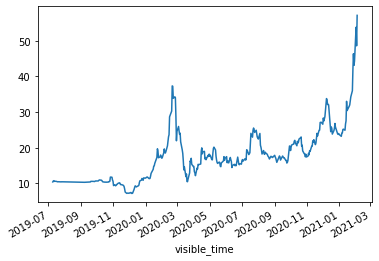

In [91]:
df['close'].plot()

In [27]:
# 如上的相关性只是过去较长的一段时间内的样本的相关性，用这个值来估计未来的相关性显然是不合理的， 因为它使用了较长的历史数据，
# 很多数据已经与当前的市场环境无关。
# 一个想法是将这段较长的样本区间根据某个因子（统计量或者标量）来划分成不同的样本区间， 比如可以使用两根均线的相对大小计算出来的牛熊指标。
# 再比如可以根据波动率统计量（统计量都需要选定一段样本长度）。

In [30]:
# 下面使用30分钟的收盘价到收盘价的估计量来估计波动率，样本长度为7天。使用辛克莱的方法
# 日内波动占总体波动的比率
percentage = open_to_close_rets.std() / close_to_close_rets.std()
percentage

0.7707581995906085

In [33]:
# 下载分钟级别的数据
start = pd.Timestamp("2019-11-09", tz='Asia/Shanghai')
end = pd.Timestamp("2021-02-05", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['SPCE_STK_USD_SMART'])
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)
ts: TimeSeries = ts_repo.find_one("ibMinBar")
ts.download_data(command)

(MainThread) 2021-02-08 17:52:53 INFO     time_series.py:364 下载完成， 共下载了33120个数据


,co,cc,oc,oo
visible_time,,,,
2019-07-09 04:00:00+08:00,0.046825,0.024622,-0.000958,0.045867
2019-07-10 04:00:00+08:00,0.010237,0.008384,-0.022203,-0.011965
